In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path
#data_folder = Path("C:/Users/merri/OneDrive/Nan's NW/Capstone")

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


# import Natural Language Tookit
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

import re

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as k
from tensorflow.keras.metrics import AUC

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import mean_squared_error as MSE

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from sklearn.feature_extraction.text import CountVectorizer

from packaging import version
from tensorflow.python.client import device_lib

# for BERT tokenization
# from transformers import BertTokenizer, TFAutoModel

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# for Glove tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

# SMOTE oversampling
from imblearn.over_sampling import SMOTE


In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

device_lib.list_local_devices()

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.10.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14136367398132968950
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22385000448
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7582436338531880019
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9"
 xla_global_id: 416903419]

In [4]:
# Download the stopwords and punkt tokenizer models
nltk.download('stopwords')
nltk.download('punkt')

# Function to determine the type of product number
def determine_number_type(s):
    if '.' in s:
        return 'float'
    elif '-' in s:
        return 'hyphenated'
    elif s.isdigit():  # checks if the string contains only numbers
        return 'numeric'
    else:
        return 'alphanumeric'

stop_words = set(stopwords.words('english'))

# Create a function to tokenize the Product_Description column based on the specified requirements:
# Convert underscores _ to spaces.
# Tokenize using spaces, commas, and other special characters.
# Filter out stopwords.
def combined_tokenizer(description):
    # Convert underscores to spaces
    description = description.replace("_", " ")

    # Tokenize based on spaces, commas, and other delimiters
    tokens = re.split(r'[ ,;()\n]+', description)

    # Tokenize further using alphanumeric boundaries
    refined_tokens = []
    for token in tokens:
        refined_tokens.extend(re.findall(r'\d+|\D+', token))
    
    # Filter out stopwords
    refined_tokens = [word for word in refined_tokens if word.lower() not in stop_words and len(word) > 1]

    return refined_tokens

# Assuming digits in Product_Description are refering to size/dimension of a product
# and may not play a significant role in classification.
# Remove digits and mean from a list of tokens and .

def remove_digits(tokens_list):
    return [token for token in tokens_list if not token.isdigit()]

def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\reedb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\reedb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# Import dataset
df=pd.read_csv('../Dataset/Commodity_Item_Master.csv')

# Delete the last two columns
df1 = df.drop(df.columns[-1:], axis = 1)

# Rename columns
columns = df1.columns.to_list() # NOTE: Commodity_Item_Master.csv has 'ï»¿Product #' column with non-alphanumeric characters; will rename to 'Product ID'
rename_dict = {
    columns[0]:'Product ID',
    columns[2]:'UNSPSC CODES',
    columns[3]:'UNSPSC Code Description'
}
df2 = df1.rename(columns = rename_dict)


# Delete rows with missing values
df3 = df2.dropna()

# Convert'UNSPSC CODES' from float to int
df3['UNSPSC CODES']=df3['UNSPSC CODES'].astype(int)

# Looks like row 294 has false UNSPSC Codes and UNSPSC Code Description, delete row 294
df4 = df3.drop(294)

# keep one row from the set of duplicated rows
df5 = df4.drop_duplicates(subset='Product ID', keep='first')

df5['ProductID_Type'] = df5['Product ID'].apply(determine_number_type)

### DESCRIPTIONS and Product ID
# Convert to lowercase for consistency
df5['DESCRIPTIONS']=df5['DESCRIPTIONS'].str.lower()
df5['Product ID']=df5['Product ID'].str.lower()

# Remove periods
df5['DESCRIPTIONS'] = df5['DESCRIPTIONS'].str.replace('.', '')
# ***** NOTE - PLEASE REVIEW: Do we need to remove periods to Product ID as well? *****
# df5['Product ID'] = df5['Product ID'].str.replace('.', '')

# Apply the function to the DESCRIPTIONS column
df5['TOKENS'] = df5['DESCRIPTIONS'].apply(combined_tokenizer)

# combine 'Product ID' and 'DESCRIPTIONS' columns into one column
df5['Product_Description'] = df5[['Product ID', 'DESCRIPTIONS']].apply(lambda x: ','.join(x), axis=1)

# Delete the row with '_na' as DESCRIPTIONS
df6 = df5[df5['DESCRIPTIONS']!='_na']


# Apply the function to the TOKENS column
df6['TOKENS'] = df6['TOKENS'].apply(remove_digits)

### UNSPSC Code Description
#### UNSPSC CODES_Segment Level
# Check how many types of Segments, which is the first level, in the UNSPSC CODES
# Convert UNSPSC CODES to string and extract the first two digits
df6['Segment'] = df6['UNSPSC CODES'].astype(str).str[:2]
df6['Family'] = df6['UNSPSC CODES'].astype(str).str[:4]
df6['Class'] = df6['UNSPSC CODES'].astype(str).str[:6]
df6['Commodity'] = df6['UNSPSC CODES'].astype(str).str[:8]

# Delete the only one entry that uses 811115035.
df6 = df6[df6['UNSPSC CODES'] != '811115035']

# Remove the string 'mm' from a list of tokens
df6['TOKENS'] = df6['TOKENS'].apply(lambda tokens: [token for token in tokens if token != 'mm'])


In [6]:
df6

,Product ID,DESCRIPTIONS,UNSPSC CODES,UNSPSC Code Description,ProductID_Type,TOKENS,Product_Description,Segment,Family,Class,Commodity
0,0,set up sheet for ccx600 d,55101516,Operation or instruction manuals,numeric,"[set, sheet, ccx]","0,set up sheet for ccx600 d",55,5510,551015,55101516
1,1000.004,"res, 270 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.004,res, 270 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706
2,1000.005,"res, 200 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.005,res, 200 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706
3,1000.06,"res, 56k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.06,res, 56k, cf, 1/8 w, 5%",32,3212,321217,32121706
4,1000.075,"res, 100k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.075,res, 100k, cf, 1/8 w, 5%",32,3212,321217,32121706
...,...,...,...,...,...,...,...,...,...,...,...
25167,z462358-14f,"36k,5%,1/16w,0402,lf",32121706,Resistor or capacito,hyphenated,[lf],"z462358-14f,36k,5%,1/16w,0402,lf",32,3212,321217,32121706
25168,z462358-42f,"res,1/16w,510k ohms,5%,0402",32121706,Resistor or capacito,hyphenated,"[res, ohms]","z462358-42f,res,1/16w,510k ohms,5%,0402",32,3212,321217,32121706
25169,z468610-04f,"c0g,15pf±025pf,50v,0201,lf",32121706,Resistor or capacito,hyphenated,"[pf±, pf, lf]","z468610-04f,c0g,15pf±025pf,50v,0201,lf",32,3212,321217,32121706
25170,z480086-01f,"side,actuated,16n,smd",39122221,Switch part or acces,hyphenated,"[side, actuated, smd]","z480086-01f,side,actuated,16n,smd",39,3912,391222,39122221


<Axes: ylabel='Commodity'>

19720

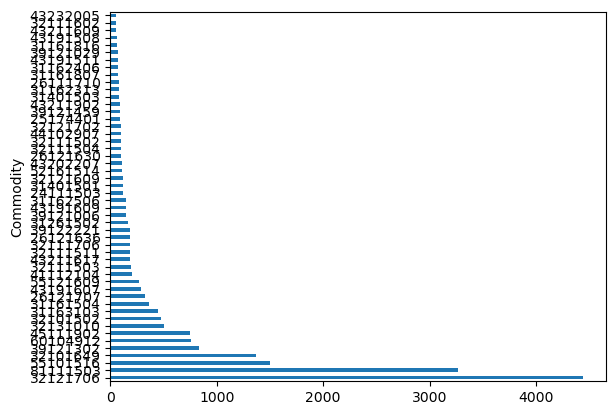

In [7]:
# can we get a dataframe of the top 50 Commodity CODES?
y_top_50 = df6['Commodity'].value_counts().head(50)
df7 = df6[df6['Commodity'].isin(y_top_50.index.tolist())]
df7['Commodity'].value_counts().plot(kind='barh')

len(df7)

In [8]:
# Use label encoder to encode the Family CODES
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df7['Commodity'])


In [9]:
count_vectorizer = CountVectorizer(lowercase=True, token_pattern=r'\b[a-zA-Z]{2,}\b', stop_words='english', analyzer='word', max_features=1000)
X = count_vectorizer.fit_transform(df7['Product_Description'])
X.shape

(19720, 1000)

In [10]:
# use the inverse_transform() method to map X_count back to the original text data
X_text = count_vectorizer.inverse_transform(X)
df7['Bag of Words'] = X_text

In [11]:
df7

,Product ID,DESCRIPTIONS,UNSPSC CODES,UNSPSC Code Description,ProductID_Type,TOKENS,Product_Description,Segment,Family,Class,Commodity,Bag of Words
0,0,set up sheet for ccx600 d,55101516,Operation or instruction manuals,numeric,"[set, sheet, ccx]","0,set up sheet for ccx600 d",55,5510,551015,55101516,"[set, sheet]"
1,1000.004,"res, 270 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.004,res, 270 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706,"[res, ohm, cf]"
2,1000.005,"res, 200 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.005,res, 200 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706,"[res, ohm, cf]"
3,1000.06,"res, 56k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.06,res, 56k, cf, 1/8 w, 5%",32,3212,321217,32121706,"[res, cf]"
4,1000.075,"res, 100k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.075,res, 100k, cf, 1/8 w, 5%",32,3212,321217,32121706,"[res, cf]"
...,...,...,...,...,...,...,...,...,...,...,...,...
25167,z462358-14f,"36k,5%,1/16w,0402,lf",32121706,Resistor or capacito,hyphenated,[lf],"z462358-14f,36k,5%,1/16w,0402,lf",32,3212,321217,32121706,[lf]
25168,z462358-42f,"res,1/16w,510k ohms,5%,0402",32121706,Resistor or capacito,hyphenated,"[res, ohms]","z462358-42f,res,1/16w,510k ohms,5%,0402",32,3212,321217,32121706,"[res, ohms]"
25169,z468610-04f,"c0g,15pf±025pf,50v,0201,lf",32121706,Resistor or capacito,hyphenated,"[pf±, pf, lf]","z468610-04f,c0g,15pf±025pf,50v,0201,lf",32,3212,321217,32121706,[lf]
25170,z480086-01f,"side,actuated,16n,smd",39122221,Switch part or acces,hyphenated,"[side, actuated, smd]","z480086-01f,side,actuated,16n,smd",39,3912,391222,39122221,[smd]


In [12]:
# split X and y_encoded into training test and validation sets
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X, y_encoded, test_size=0.1, random_state=42)
X_train_enc, X_val_enc, y_train_enc, y_val_enc = train_test_split(X_train_enc, y_train_enc, test_size=0.1, random_state=42)

In [13]:
# convert the true labels from one-hot encoded format to class labels
y_test_labels_enc = label_encoder.inverse_transform(y_test_enc)


In [15]:
# # create the SMOTE object
smote = SMOTE()

# # fit and apply SMOTE to the one-hot-encoded training data
X_train_smote_enc, y_train_smote_enc = smote.fit_resample(X_train_enc, y_train_enc)

# # print the shape of the new training data
print('Shape of X_train_count_smote:', X_train_smote_enc.shape)
print('Shape of y_train_smote:', y_train_smote_enc.shape)


Shape of X_train_count_smote: (181950, 1000)
Shape of y_train_smote: (181950,)


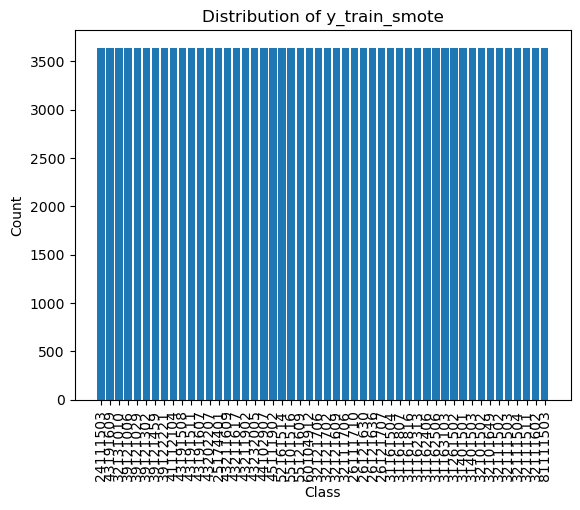

In [16]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # create a dataframe of the class counts
class_counts = pd.DataFrame(label_encoder.inverse_transform(y_train_smote_enc), columns=['class']).value_counts().reset_index(name='count')

# plot the class counts as a bar chart
plt.bar(class_counts['class'], class_counts['count'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of y_train_smote')
plt.xticks(rotation=90)
plt.show();


In [17]:
# default model callback settings

def create_checkpoint(model_name):
    return ModelCheckpoint(
        filepath=model_name,
        mode='min',
        save_best_only=True,
        save_weights_only=False,
        monitor='val_loss',
        verbose=1
    )

early_stopping = EarlyStopping(patience=10, restore_best_weights=True,monitor='val_loss')

In [18]:
k.clear_session()
model_count = Sequential()
model_count.add(Dense(64, input_shape=(X_train_smote_enc.shape[1],), activation='relu'))
model_count.add(Dropout(0.5))
model_count.add(Dense(50, activation='softmax'))
model_count.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_count.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                64064     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                3250      
                                                                 
Total params: 67,314
Trainable params: 67,314
Non-trainable params: 0
_________________________________________________________________


In [19]:
history_count = model_count.fit(X_train_enc.toarray(), y_train_enc, validation_data=(X_val_enc.toarray(), y_val_enc), epochs=100, batch_size=64,
        callbacks=[create_checkpoint('best_model_nn_count_prodmod_enc.h5'),early_stopping], verbose=1)

Epoch 1/100
229/250 [==========================>...] - ETA: 0s - loss: 2.7128 - accuracy: 0.4517
Epoch 1: val_loss improved from inf to 1.49006, saving model to best_model_nn_count_prodmod_enc.h5
250/250 [==============================] - 2s 3ms/step - loss: 2.6254 - accuracy: 0.4671 - val_loss: 1.4901 - val_accuracy: 0.6885
Epoch 2/100
241/250 [===========================>..] - ETA: 0s - loss: 1.2589 - accuracy: 0.7155
Epoch 2: val_loss improved from 1.49006 to 0.85441, saving model to best_model_nn_count_prodmod_enc.h5
250/250 [==============================] - 1s 2ms/step - loss: 1.2480 - accuracy: 0.7180 - val_loss: 0.8544 - val_accuracy: 0.8231
Epoch 3/100
220/250 [=========================>....] - ETA: 0s - loss: 0.8436 - accuracy: 0.8077
Epoch 3: val_loss improved from 0.85441 to 0.57767, saving model to best_model_nn_count_prodmod_enc.h5
250/250 [==============================] - 0s 2ms/step - loss: 0.8333 - accuracy: 0.8101 - val_loss: 0.5777 - val_accuracy: 0.8704
Epoch 4/100

In [21]:
pred_nn = model_count.predict(X_test_enc.toarray())
pred_nn_decoded = label_encoder.inverse_transform(np.argmax(pred_nn, axis=1))
print_validation_report(y_test_labels_enc, pred_nn_decoded)


62/62 [==============================] - 0s 1ms/step
Classification Report
              precision    recall  f1-score   support

    24111503       0.92      1.00      0.96        11
    25174401       1.00      1.00      1.00         6
    26111710       1.00      0.80      0.89         5
    26121630       0.83      0.50      0.62        10
    26121636       1.00      0.93      0.96        14
    26121707       0.90      0.96      0.93        28
    31161504       1.00      1.00      1.00        53
    31161807       1.00      0.75      0.86        12
    31161816       1.00      0.78      0.88         9
    31162313       1.00      0.83      0.91         6
    31162406       1.00      0.60      0.75        10
    31162506       0.88      1.00      0.93        14
    31163103       1.00      0.98      0.99        47
    31261502       0.93      1.00      0.97        14
    31401501       0.94      1.00      0.97        15
    31401503       1.00      1.00      1.00         8
    32

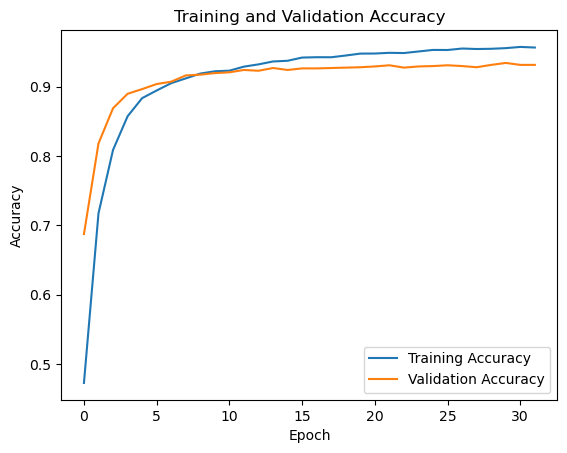

In [ ]:
# plot the training and validation accuracy
plt.plot(history_count.history['accuracy'])
plt.plot(history_count.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show();

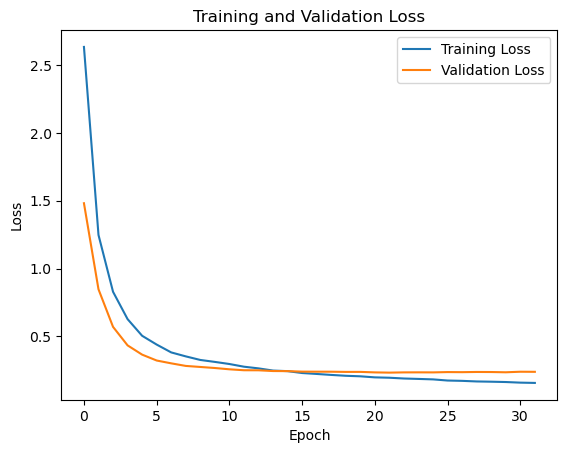

In [ ]:
# plot the training and validation loss
plt.plot(history_count.history['loss'])
plt.plot(history_count.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show();


In [51]:
# create the logistic regression object
logreg = LogisticRegression(max_iter=1000)

# fit the model to the training data
logreg.fit(X_train_smote_enc, y_train_smote_enc)


LogisticRegression(max_iter=1000)

In [52]:
pred_lr = logreg.predict(X_test_enc)
pred_lr_decoded = label_encoder.inverse_transform(pred_lr)
print_validation_report(y_test_labels_enc, pred_lr_decoded)


Classification Report
              precision    recall  f1-score   support

    24111503       0.92      1.00      0.96        11
    25174401       1.00      1.00      1.00         6
    26111710       1.00      0.80      0.89         5
    26121630       0.47      0.70      0.56        10
    26121636       0.93      1.00      0.97        14
    26121707       0.90      1.00      0.95        28
    31161504       1.00      0.98      0.99        53
    31161807       1.00      0.75      0.86        12
    31161816       1.00      0.78      0.88         9
    31162313       1.00      0.83      0.91         6
    31162406       0.78      0.70      0.74        10
    31162506       0.81      0.93      0.87        14
    31163103       1.00      0.91      0.96        47
    31261502       0.93      1.00      0.97        14
    31401501       0.94      1.00      0.97        15
    31401503       0.70      0.88      0.78         8
    32101502       0.85      1.00      0.92        50
    3

In [53]:
# # create a MLPClassifier object
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=25, verbose=True, early_stopping=True)


In [54]:
# # fit the model on the training data
mlp.fit(X_train_smote_enc, y_train_smote_enc)


Iteration 1, loss = 0.89262207
Validation score: 0.914592
Iteration 2, loss = 0.27846706
Validation score: 0.919209
Iteration 3, loss = 0.25606047
Validation score: 0.919648
Iteration 4, loss = 0.24669317
Validation score: 0.920253
Iteration 5, loss = 0.24116377
Validation score: 0.921572
Iteration 6, loss = 0.23731403
Validation score: 0.920802
Iteration 7, loss = 0.23462746
Validation score: 0.921242
Iteration 8, loss = 0.23248011
Validation score: 0.921847
Iteration 9, loss = 0.23102526
Validation score: 0.921462
Iteration 10, loss = 0.22958343
Validation score: 0.916131
Iteration 11, loss = 0.22865382
Validation score: 0.921022
Iteration 12, loss = 0.22767205
Validation score: 0.919428
Iteration 13, loss = 0.22709688
Validation score: 0.922067
Iteration 14, loss = 0.22663556
Validation score: 0.922121
Iteration 15, loss = 0.22609706
Validation score: 0.919154
Iteration 16, loss = 0.22573679
Validation score: 0.922561
Iteration 17, loss = 0.22525086
Validation score: 0.920583
Iterat

MLPClassifier(early_stopping=True, max_iter=25, verbose=True)

In [56]:
pred_mlp = mlp.predict(X_test_enc)
pred_mlp_decoded = label_encoder.inverse_transform(pred_mlp)
print_validation_report(y_test_labels_enc, pred_mlp_decoded)


Classification Report
              precision    recall  f1-score   support

    24111503       0.91      0.91      0.91        11
    25174401       1.00      1.00      1.00         6
    26111710       1.00      0.80      0.89         5
    26121630       0.39      0.70      0.50        10
    26121636       1.00      1.00      1.00        14
    26121707       0.87      0.96      0.92        28
    31161504       1.00      1.00      1.00        53
    31161807       1.00      0.75      0.86        12
    31161816       1.00      0.78      0.88         9
    31162313       1.00      0.83      0.91         6
    31162406       0.67      0.60      0.63        10
    31162506       0.93      0.93      0.93        14
    31163103       0.98      0.91      0.95        47
    31261502       0.93      1.00      0.97        14
    31401501       0.94      1.00      0.97        15
    31401503       0.67      0.75      0.71         8
    32101502       0.83      1.00      0.91        50
    3

In [57]:
# create the RandomForestClassifier object
rfc = RandomForestClassifier(verbose=1, random_state=42)

# Train the RandomForestClassifier model
rfc.fit(X_train_smote_enc, y_train_smote_enc)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   36.1s finished


RandomForestClassifier(random_state=42, verbose=1)

In [58]:
pred_rfc = rfc.predict(X_test_enc)
pred_rfc_decoded = label_encoder.inverse_transform(pred_rfc)
print_validation_report(y_test_labels_enc, pred_rfc_decoded)

Classification Report
              precision    recall  f1-score   support

    24111503       0.92      1.00      0.96        11
    25174401       1.00      1.00      1.00         6
    26111710       1.00      1.00      1.00         5
    26121630       0.35      0.70      0.47        10
    26121636       1.00      1.00      1.00        14
    26121707       0.90      0.96      0.93        28
    31161504       1.00      0.98      0.99        53
    31161807       1.00      0.75      0.86        12
    31161816       1.00      0.78      0.88         9
    31162313       0.71      0.83      0.77         6
    31162406       0.71      1.00      0.83        10
    31162506       0.68      0.93      0.79        14
    31163103       0.98      0.98      0.98        47
    31261502       0.93      1.00      0.97        14
    31401501       0.94      1.00      0.97        15
    31401503       0.73      1.00      0.84         8
    32101502       0.86      1.00      0.93        50
    3

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [59]:
# create the MultinomialNB object
nb = MultinomialNB()

# fit the model to the training data
nb.fit(X_train_smote_enc, y_train_smote_enc)


MultinomialNB()

In [60]:
pred_nb = nb.predict(X_test_enc)
pred_nb_decoded = label_encoder.inverse_transform(pred_nb)
print_validation_report(y_test_labels_enc, pred_nb_decoded)

Classification Report
              precision    recall  f1-score   support

    24111503       0.15      1.00      0.27        11
    25174401       0.75      1.00      0.86         6
    26111710       0.83      1.00      0.91         5
    26121630       0.44      0.70      0.54        10
    26121636       0.72      0.93      0.81        14
    26121707       0.69      0.86      0.76        28
    31161504       0.98      0.96      0.97        53
    31161807       1.00      0.67      0.80        12
    31161816       1.00      0.78      0.88         9
    31162313       1.00      0.67      0.80         6
    31162406       0.46      0.60      0.52        10
    31162506       0.59      0.93      0.72        14
    31163103       1.00      0.85      0.92        47
    31261502       0.88      1.00      0.93        14
    31401501       0.88      0.93      0.90        15
    31401503       0.60      0.75      0.67         8
    32101502       0.80      0.96      0.87        50
    3

In [61]:
# create the SVM object
svm = SVC()

# fit the model to the training data
svm.fit(X_train_smote_enc, y_train_smote_enc)


SVC()

In [62]:
pred_svm = svm.predict(X_test_enc)
pred_svm_decoded = label_encoder.inverse_transform(pred_svm)
print_validation_report(y_test_labels_enc, pred_svm_decoded)

Classification Report
              precision    recall  f1-score   support

    24111503       0.92      1.00      0.96        11
    25174401       1.00      1.00      1.00         6
    26111710       1.00      0.80      0.89         5
    26121630       0.35      0.70      0.47        10
    26121636       1.00      0.93      0.96        14
    26121707       0.84      0.96      0.90        28
    31161504       1.00      0.98      0.99        53
    31161807       1.00      0.58      0.74        12
    31161816       1.00      0.78      0.88         9
    31162313       1.00      0.33      0.50         6
    31162406       0.67      0.80      0.73        10
    31162506       0.73      0.79      0.76        14
    31163103       0.98      0.98      0.98        47
    31261502       0.93      1.00      0.97        14
    31401501       0.93      0.93      0.93        15
    31401503       0.71      0.62      0.67         8
    32101502       0.86      0.98      0.92        50
    3

In [63]:
# create the XGBClassifier object
xgb = XGBClassifier(objective='multi:softmax', num_class=50)


In [64]:
eval_set = [(X_val_enc, y_val_enc)]

# fit the model to the training data
xgb.fit(X_train_smote_enc, y_train_smote_enc, eval_set=eval_set, 
        early_stopping_rounds=5, verbose=True)


[0]	validation_0-mlogloss:0.87649
[1]	validation_0-mlogloss:0.63592
[2]	validation_0-mlogloss:0.56115
[3]	validation_0-mlogloss:0.52424
[4]	validation_0-mlogloss:0.49641
[5]	validation_0-mlogloss:0.47203
[6]	validation_0-mlogloss:0.45222
[7]	validation_0-mlogloss:0.43582
[8]	validation_0-mlogloss:0.42195
[9]	validation_0-mlogloss:0.41074
[10]	validation_0-mlogloss:0.40242
[11]	validation_0-mlogloss:0.39375
[12]	validation_0-mlogloss:0.38635
[13]	validation_0-mlogloss:0.37861
[14]	validation_0-mlogloss:0.37223
[15]	validation_0-mlogloss:0.36686
[16]	validation_0-mlogloss:0.36284
[17]	validation_0-mlogloss:0.35907
[18]	validation_0-mlogloss:0.35552
[19]	validation_0-mlogloss:0.35202
[20]	validation_0-mlogloss:0.34886
[21]	validation_0-mlogloss:0.34435
[22]	validation_0-mlogloss:0.34115
[23]	validation_0-mlogloss:0.33892
[24]	validation_0-mlogloss:0.33707
[25]	validation_0-mlogloss:0.33535
[26]	validation_0-mlogloss:0.33384
[27]	validation_0-mlogloss:0.33213
[28]	validation_0-mlogloss:0.3

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=50,
              num_parallel_tree=None, ...)

In [65]:
pred_xgb = xgb.predict(X_test_enc)
pred_xgb_decoded = label_encoder.inverse_transform(pred_xgb)
print_validation_report(y_test_labels_enc, pred_xgb_decoded)

Classification Report
              precision    recall  f1-score   support

    24111503       0.92      1.00      0.96        11
    25174401       1.00      1.00      1.00         6
    26111710       1.00      0.80      0.89         5
    26121630       0.60      0.60      0.60        10
    26121636       1.00      1.00      1.00        14
    26121707       0.93      0.96      0.95        28
    31161504       1.00      1.00      1.00        53
    31161807       1.00      0.75      0.86        12
    31161816       1.00      0.67      0.80         9
    31162313       0.86      1.00      0.92         6
    31162406       0.80      0.80      0.80        10
    31162506       0.87      0.93      0.90        14
    31163103       0.98      0.98      0.98        47
    31261502       0.93      1.00      0.97        14
    31401501       0.93      0.93      0.93        15
    31401503       0.73      1.00      0.84         8
    32101502       0.89      1.00      0.94        50
    3